In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from matplotlib import *
from __future__ import division

import CoolProp.CoolProp as CP
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import xlrd

rc('text',usetex = True)
rc('font', family='Times New Roman')

In [2]:
mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}']}
#plt.rcParams.update(mpl_params)

In [3]:
def set_all_fontsizes_from_axis(ax):
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
            
        item.set_fontsize(16)

In [4]:
CP.PropsSI('Prandtl','T',25+273.15,'P',100000,'air')

0.7072891359796488

In [5]:
def HEX(L1,L2,L3,Di,De,Xt,Xl,Nfin,Deltaf,delta_h,arranjo,vazao_cfm,m_fluid,x_f,p_d,T_a_in,T_a_out):
    
    
    ## Properties - Air
    rho_a_i  = CP.PropsSI('D','T',T_a_in+273.15,'P',100000,'air') 
    rho_a_o = CP.PropsSI('D','T',T_a_out+273.15,'P',100000,'air') 
    rho = (rho_a_i + rho_a_o)/2
    
    
    mi = 18.5e-6
    cp_ar = 1005
    Pr_ar = 0.707 #aprox para 25ºC
    
    ## Properties - Water
    rho_f_i=992 #T = 40ºC
    rho_f_o= 993.3 #T = 37ºC
    rho_f_m=((1/2)*(1/rho_f_i+1/rho_f_o))**(-1) 
    mi_f= 0.0006572 #0.001136 #T = 40ºC
    Pr_f = 4.342 #40ºC
    k_f = 0.56285 #40ºC
    
    
    Dc = De+2*Deltaf
    N_r = L2/Xl
    if (arranjo == 0): 
        N_t = (L2*L3)/(Xl*Xt)
    #if (arranjo == 1):
        #N_t = (L3/Xt)*(L2/Xl+1)/2+(L3/Xt-1)*(L2/Xl-1)/2
    if (arranjo == 2):
        N_t = 0.5*(L2/Xl)*(2*L3/Xt-1)
        N_t = 12
    print(N_t)
    #N_t = 12
      
    theta = np.arctan(p_d/x_f) #*180/(np.pi)
    
    p_f = 1/Nfin
    
    k_w = 238.8 #aproximado
    Rt_CD = math.log(De/Di)/(2*np.pi*L1*N_t*k_w)
    
    Delta_Pe_list = []
    Rte_list = []
    
    vazao = vazao_cfm *0.00047194745 #m^3/s
        #Perda de carga externa
    if (arranjo==0):
        Amin_e = ((Xt-De)*L1-(Xt-De)*Deltaf*Nfin*L1)*(L3/Xt)
    else:
        pt = ((Xt/2)**2+Xl**2)**0.5
        a = ((Xt-De)-(Xt-De)*Deltaf*Nfin)/2
        b = (pt-De)-(Xt-De)*Deltaf*Nfin
        if (a<b):
            c=2*a
        else:
            c=2*b
        Amin_e = ((L3/Xt-1)*c+(Xt-De)-(Xt-De)*Deltaf*Nfin)*L1       

    Afr = L1*L3
    sigma = Amin_e/Afr
    Ae_p = np.pi*De*(L1-Deltaf*Nfin*L1)*N_t+2*(L2*L3-np.pi*De**2*N_t/4)
    Ae_f = 2*Nfin*L1*(L2*L3/np.cos(theta)-np.pi*De**2*N_t/4)+2*L3*Deltaf*Nfin*L1/np.cos(theta)
    Ae = Ae_p+Ae_f
    At = np.pi*De*L1*N_t
    sigmae = (L1*L3-L3*Deltaf*Nfin*L1)/(L3*L1)
    d_h=(4*Amin_e*L2)/Ae
    print(d_h)
    d_c = Dc

    uar = vazao/(L1*L3)
    u_max = uar/sigma

    Re = u_max*rho*Dc/mi
    print(Re)
    c5 = 0.4606-0.01336*((p_f/Xl)**0.58)*(math.log(Ae/At))*(math.tan(theta))**(-1.5)
    c6 = 3.247*(p_f/Xt)**1.4*math.log(Ae/At)
    c7 = -20.113/(math.log(Re))   
    fe = 0.01915*(Re**c5)*((math.tan(theta))**c6)*((p_f/Xl)**c7)*((math.log(Ae/At))**(-5.35))*((d_h/d_c)**1.3796)*(N_r**(-0.0916))   
    Ge = rho*u_max

    Delta_Pe = Ge**2/(2*rho)*((fe*(Ae/Amin_e)*(rho_a_i/rho))+(1+sigmae**2)*(rho_a_i/rho_a_o-1)) #+(1+sigmae**2))#falta um termo
    #Delta_Pe_list.append(Delta_Pe) 


        #Resistência térmica externa

    c1 = -0.229 + 0.115*((p_f/d_c)**0.6)*((Xl/d_h)**0.54)*(N_r**(-0.284))*math.log(0.5*math.tan(theta)) 
    c2 = -0.251 + (0.232*N_r**(1.37))/(math.log(Re)-2.303)
    c3 = -0.439*(p_f/d_h)**(0.09)*(Xl/Xt)**(-1.75)*N_r**(-0.93)
    c4 = 0.502*(math.log(Re)-2.54)

    je = 0.324*(Re**c1)*((p_f/Xl)**c2)*((math.tan(theta))**c3)*((Xl/Xt)**c4)*N_r**0.428


    he = je*rho*u_max*cp_ar*Pr_ar**(-0.666666)
    m = ((2*he)/(k_w*Deltaf))**0.5

    P_m = Xt/2
    P_l = (((Xt/2)**2+Xl**2)**0.5)/2
    R_eq =1.27*P_m*(P_l/P_m-0.3)**0.5
    phi = (R_eq/(Di/2)-1)*(1+0.35*math.log(R_eq/(Di/2)))
    eta = math.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
    eta_e =1-(Ae_f/Ae)*(1-eta)

    Rt_CE = 1/(eta_e*he*Ae)
    Rte_list.append(Rt_CE)


    Lh=(L1+2*delta_h)*N_t
    Ai=np.pi*Di*L1*N_t
    Amin_i = np.pi*(Di**2)/4
    Gi=m_fluid/Amin_i
    Re_i=(Gi*Di)/mi_f
    if Re_i<2300:
        f_i=16/Re_i
        Nusselt_i=3.66
    else:
        if Re_i>2300 and Re_i<4000:
            f_i=0.0054+(2.3*10**(-8))*Re_i**(3/2)
        if Re_i>4000 and Re_i<(10**7):
            f_i=0.00128+0.1143*Re_i**(-1/3.2154)
        if Re_i>2300 and Re_i<(5*(10**6)):
            Nusselt_i =((f_i/2)*(Re_i-1000)*Pr_f)/(1+12.7*((f_i/2)**0.5)*(Pr_f**(2/3)-1))

    h_hex_i=(Nusselt_i*k_f)/Di
    Rt_CI=1/(h_hex_i*Ai)
    Delta_Pi=((Gi**2)/(2*rho_f_i))*(2*(rho_f_i/rho_f_o-1)+4*f_i*Lh*rho_f_i/(Di*rho_f_m))

    W_p = Delta_Pi*m_fluid/rho_f_i
    
    #Rte_array = np.array(Rte_list)
    UA_array = (Rt_CD+Rt_CE+Rt_CI)**-1
    W_array  = (np.asarray(Delta_Pe_list)*0.00047194745*rho)*x/(rho*0.1)
    
    print(theta*180/np.pi)
    
    return(UA_array,Delta_Pe)


In [10]:
L1 = 0.11
L2 = 0.043 #0.0215 #0.043
L3 = 0.1524 #0.125 #0.152

Di = 0.00694 #694
De = 0.00794 #794

Xt = 0.0254
Xl = 0.0221

Nfin = 39/L1

Deltaf = 0.0002 #0.00025

delta_h = 0.0016

arranjo = 0
x = 80
m_fluid = 36.7/3600

In [11]:
cfm_1 = [41.5,50.5,59.0,69.6,79.4]
m_fluid_1 = [36.7,42.2,46.6,47.8,49.8]
UA_1 =  [8.4,9.0,9.5,9.9,10.3]
dP_1 = [4.2,6.4,8.6,11.6,14.8]
W_1  = [0.818420218,1.520958305,2.400131873,3.807149077,5.542601938]

cfm_2 = [39.8,48.8,60.0,70.4,80.5]
m_fluid_2 = [42.5,47.3,53.1,57.3,60.9]
UA_2 = [9.9,10.7,11.8,12.6,13.3]
dP_2 = [6.9,10.3,15.3,20.8,26.1]
W_2 = [1.286586999,2.382417293,4.3189455,6.914383018,9.914460144]
Ta_i_2 = [20.5,20.5,20.3,20.3,20.2]
Ta_o_2 = [26.7,26.1,25.5,25.0,24.6]



cfm_3 = [39.8,51.6,59.8,70.4,79.9]
m_fluid_3 = [70.3,84.2,94.3,100.5,110.8]
UA_3 =  [19.2,21.7,23.3,24.9,26.6]
dP_3 = [8.7,14.3,18.9,25.3,32.4]
W_3  = [1.628977996,3.489680235,5.334170713,8.411238811,12.20898464]
Ta_i_3 = [20.3,20.0,20.0,20.3,20.4]
Ta_o_3 = [30.4,29.4,28.9,28.5,28.1]

In [12]:
UA_3_n = []
dP_3_n = []
for i in range(5):
    A,B = HEX(L1,L2,L3,Di,De,Xt,Xl,Nfin,Deltaf,delta_h,arranjo,cfm_2[i],m_fluid_2[i]/3600,0.0035,0.0012,Ta_i_2[i],Ta_o_2[i])
    UA_3_n.append(A)
    dP_3_n.append(B)

11.67420814479638
0.0034133974730229813
928.906692839807
18.924644416051233
11.67420814479638
0.0034133974730229813
1140.0938150820532
18.924644416051233
11.67420814479638
0.0034133974730229813
1403.636721807514
18.924644416051233
11.67420814479638
0.0034133974730229813
1648.3062179262079
18.924644416051233
11.67420814479638
0.0034133974730229813
1886.3659997815282
18.924644416051233


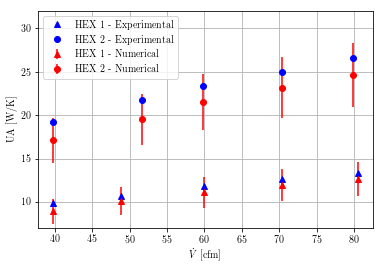

In [17]:
#plt.plot(UA_1,'xr--')
#plt.plot(UA_1_n,'xb--')

#plt.plot(cfm_2,UA_2,'^r-')

plt.errorbar(cfm_2, UA_2_n,yerr=0.15*np.array(UA_2), fmt='^r',label = 'HEX 1 - Numerical')
plt.plot(cfm_2,UA_2,'^b',label = 'HEX 1 - Experimental')

plt.errorbar(cfm_3,UA_3_n,yerr=0.15*np.array(UA_3_n), fmt='or',label = 'HEX 2 - Numerical')
plt.plot(cfm_3,UA_3,'bo',label = 'HEX 2 - Experimental')

plt.ylabel('UA [W/K]')
plt.xlabel('$\dot{V}$ [cfm]')
plt.legend()
plt.grid()
plt.ylim([7,32])

plt.savefig('UA.png',format = 'png', dpi=1000,bbox_inches='tight')

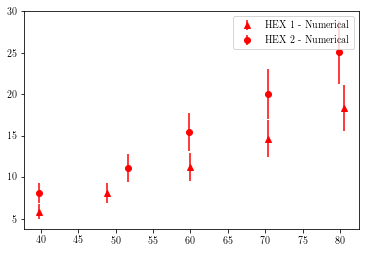

In [18]:
plt.errorbar(cfm_2, dP_2_n,yerr=0.15*np.array(dP_2_n), fmt='^r',label = 'HEX 1 - Numerical')
#plt.plot(cfm_2,dP_2,'^b',label = 'HEX 1 - Experimental')

plt.errorbar(cfm_3, dP_3_n,yerr=0.15*np.array(dP_3_n), fmt='or',label = 'HEX 2 - Numerical')
#plt.plot(cfm_3,dP_3,'ob',label = 'HEX 2 -Experimental')
plt.legend()

In [19]:
def dP(X,a,b,c): 
    V = X
    return (a*V**2 + b*V + c)

In [22]:
M = curve_fit(dP,cfm_2, dP_2_n)
M2 = curve_fit(dP,cfm_3, dP_3_n)
a_fan = -0.5304
b_fan = 50.442

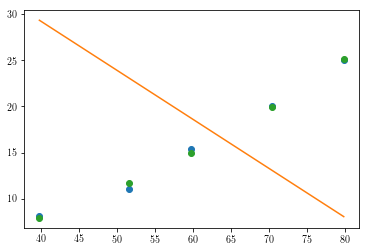

In [23]:
plt.plot(cfm_3,dP_3_n,'o')
plt.plot(cfm_3,a_fan*np.array(cfm_3)+b_fan)
plt.plot(cfm_3,dP(np.array(cfm_3),M2[0][0],M2[0][1],M2[0][2]),'o')

In [24]:
cfm_1 = max(np.roots([M[0][0],M[0][1]-a_fan,M[0][2]-b_fan]))
cfm_2 = max(np.roots([M2[0][0],M2[0][1]-a_fan,M2[0][2]-b_fan]))

In [25]:
[UA_15,dP_15] = HEX(0.11,0.043,0.1524,0.00694,0.00796,0.0254,0.0215,39/0.11,0.0002,0.0016,2,cfm_2,150/3600,0.0035,0.0012,6,4)
[UA_16,dP_16] = HEX(0.112,0.0221,0.1524,0.00694,0.0085,0.0254,0.0221,39/0.11,0.0002,0.0016,0,cfm_2,150/3600,0.00325,0.0014,6,4)

12
0.0034134272299746857
1590.73159464514
18.924644416051233
6.000000000000001
0.003221172860529384
1716.3864394328089
23.304890539203114


In [26]:
def E(UA,C_ar,C_agua,N):
    Cr = C_ar/C_agua
    NTU = UA/C_ar
    if N == 1:
        Ef = (1-np.exp(-Cr*(1-np.exp(-NTU))))/Cr
    else:
        K = 1- np.exp(-NTU/2)
        Ef = (1-np.exp(-2*K*Cr)*(1+Cr*K**2))/Cr
    return(Ef,Ef*Cr)

In [27]:
cp_a  = CP.PropsSI('C','T',5+273.15,'P',100000,'air') 
rho_a  = CP.PropsSI('D','T',5+273.15,'P',100000,'air') 
cp_w  = CP.PropsSI('C','T',5+273.15,'P',100000,'water')

In [28]:
[E_15,ECr_15] = E(UA_15,cfm_2*0.00047194745*rho_a*cp_a,150/3600*cp_w,2)
[E_16,ECr_16] = E(UA_16,cfm_1*0.00047194745*rho_a*cp_a,150/3600*cp_w,2)

In [29]:
workbook = xlrd.open_workbook('Data.xlsx')
worksheet = workbook.sheet_by_name('Plan1')

In [30]:
N = 15
m_f = np.zeros(N)
T_w_in = np.zeros(N)
T_w_out = np.zeros(N)
T_a_in = np.zeros(N)
T_a_o = np.zeros(N)
T_gab = np.zeros(N)
T_amb = np.zeros(N)

for i in range(N):
    m_f[i] = worksheet.cell(0, i).value
    T_w_in[i] = worksheet.cell(1, i).value
    T_w_out[i] = worksheet.cell(2, i).value
    T_a_in[i] = worksheet.cell(5, i).value
    T_a_o[i] = worksheet.cell(3, i).value
    T_gab[i] = worksheet.cell(4, i).value
    T_amb[i] = worksheet.cell(6, i).value

In [31]:
UA_gab = 1.75
W = 4.32
T_gab_mod = np.zeros(N)

for i in range(8):
    T_gab_mod[i] = (UA_gab*T_amb[i]+E_15*cfm_2*0.00047194745*rho_a*cp_a*T_w_in[i]+W)/(UA_gab+E_15*cfm_2*0.00047194745*rho_a*cp_a)
    
for i in range(8,15):
    T_gab_mod[i] = (UA_gab*T_amb[i]+E_16*cfm_1*0.00047194745*rho_a*cp_a*T_w_in[i]+W)/(UA_gab+E_16*cfm_1*0.00047194745*rho_a*cp_a) 


In [33]:
def Balanco(T_gab,E,Ca,UA,T_f,Wp,T_amb):
    f = E*Ca*(T_gab+(UA*(T_gab-T_f)+Wp)/(2*Ca)-T_f) - UA*(T_amb - T_gab) - Wp
    return f

In [34]:
T_gab_mod_2 = np.zeros(15)

for i in range(8):
    T_gab_mod_2[i] = fsolve(lambda T_gab: Balanco(T_gab,E_15,cfm_2*0.00047194745*rho_a*cp_a,UA_gab,T_w_in[i],W,T_amb[i]),T_w_in[i])
    
for i in range(8,15):
    T_gab_mod_2[i] = fsolve(lambda T_gab: Balanco(T_gab,E_16,cfm_1*0.00047194745*rho_a*cp_a,UA_gab,T_w_in[i],W,T_amb[i]),T_w_in[i])

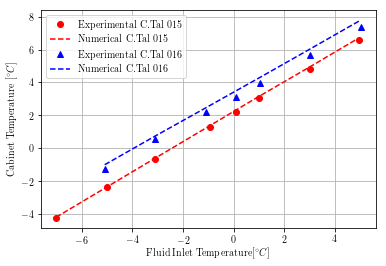

In [37]:
plt.plot(T_w_in[0:8],T_gab[0:8],'ro' , label = 'Experimental C.Tal 015')
#plt.plot(T_w_in[0:8],T_gab_mod[0:8],'r--', label = 'Numerical C.Tal 015')
plt.plot(T_w_in[0:8],T_gab_mod_2[0:8],'r--', label = 'Numerical C.Tal 015')

plt.plot(T_w_in[8:15],T_gab[8:15],'b^', label = 'Experimental C.Tal 016')
#plt.plot(T_w_in[8:15],T_gab_mod[8:15],'b--', label = 'Numerical C.Tal 016')
plt.plot(T_w_in[8:15],T_gab_mod_2[8:15],'b--', label = 'Numerical C.Tal 016')

plt.xlabel('Fluid Inlet Temperature[$^{\circ} C$]')
plt.ylabel('Cabinet Temperature [$^{\circ} C$]')

plt.grid()

plt.legend()


plt.savefig('Qc.png',format = 'png', dpi=1000,bbox_inches='tight')

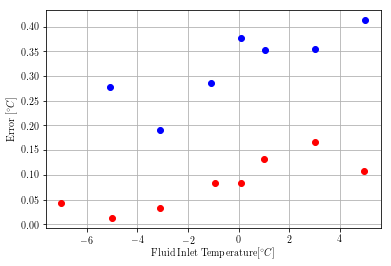

In [36]:
plt.plot(T_w_in[0:8],T_gab_mod_2[0:8]-T_gab[0:8],'ro', label = ' C.Tal 015')
plt.plot(T_w_in[8:15],T_gab_mod_2[8:15]-T_gab[8:15],'bo', label = 'C.Tal 016')

plt.xlabel('Fluid Inlet Temperature[$^{\circ} C$]')
plt.ylabel('Error [$^{\circ} C$]')
plt.grid()

plt.savefig('Error.png',format = 'png', dpi=1000,bbox_inches='tight')